In [ ]:
!pip3 install nltk

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

**Read Data**

In [4]:
data = pd.read_csv("/content/olid-training-v1.0.tsv", sep="\t")
data.drop(["subtask_b", "subtask_c"], axis=1, inplace=True)
data.head()

,id,tweet,subtask_a
0,86426,@USER She should ask a few native Americans wh...,OFF
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,16820,Amazon is investigating Chinese employees who ...,NOT
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT


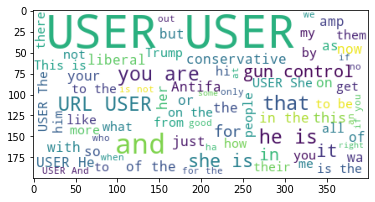

In [5]:
from wordcloud import WordCloud

texts = " ".join([x for x in data["tweet"].values])
wordcloud = WordCloud(background_color ='white', stopwords={}, min_font_size = 10).generate(texts)
plt.imshow(wordcloud)
plt.show()

**Data tag distribution**

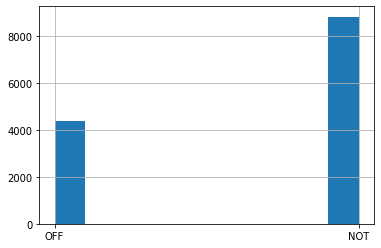

In [6]:
data.subtask_a.hist()

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**Remove Stopwords and convert special decontract words**

In [8]:
from nltk.corpus import stopwords
 
http_stopwords = ["br", "http", "https", "span", "@USER", "URL", "user", "url"]
STOPWORDS = http_stopwords + list(stopwords.words("english"))
STOPWORDS = set(STOPWORDS)
 
# preprocessing the text features by removing the short forms, stopwords, numbers
 
import re
 
def decontract_and_clean(phrase):
    # specific
    phrase = re.sub("[^a-zA-Z]",  " ", str(phrase))
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
 
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = phrase.replace('\\r', ' ')
    phrase = phrase.replace('\\"', ' ')
    phrase = phrase.replace('\\n', ' ')
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    phrase = ' '.join(e for e in phrase.split() if e.lower() not in STOPWORDS)
    return phrase
 
# Combining relevent data for processing
from tqdm import tqdm
 
def clean(df_sentences):
    clean_text_list = []
    # tqdm is for printing the status bar
    for sentance in tqdm(df_sentences.values):
        sentance = decontract_and_clean(sentance)
        clean_text_list.append(sentance.lower().strip())
    
    return clean_text_list

**Clean Data**

In [9]:
data["tweet"] = clean(data["tweet"])
data.head()

100%|██████████| 13240/13240 [00:00<00:00, 26624.12it/s]


,id,tweet,subtask_a
0,86426,ask native americans take,OFF
1,90194,go home drunk maga trump,OFF
2,16820,amazon investigating chinese employees selling...,NOT
3,62688,someone vetaken piece shit volcano,OFF
4,43605,obama wanted liberals amp illegals move red st...,NOT


**Observe Wordcloud**

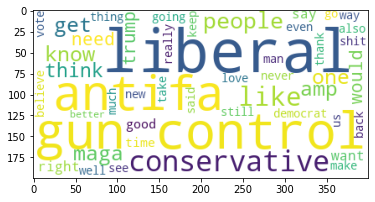

In [10]:
from wordcloud import WordCloud

texts = " ".join([x for x in data["tweet"].values])

wordcloud = WordCloud(background_color ='white', stopwords={}, min_font_size = 10).generate(texts)

plt.imshow(wordcloud)
plt.show()

**Lemmatization and Stemming**

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

lemmatizer = WordNetLemmatizer()
stemmer = LancasterStemmer()
data["tweet"] = data["tweet"].apply(lemmatizer.lemmatize)
data["tweet"] = data["tweet"].apply(stemmer.stem)

X = data["tweet"]
y = data["subtask_a"]

**Split data for Training and testing sets**

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=43)

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras.regularizers import l2, l1
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2, l1
from keras.layers import Input, Dense, Embedding, Convolution1D, MaxPooling1D,LSTM,Dropout,Flatten,Reshape

**Encode Outputs**

In [14]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train_n = y_train.apply(lambda x: 0 if x == "NOT" else 1)
y_test_n = y_test.apply(lambda x: 0 if x == "NOT" else 1)
y_train_n = y_train_n.values.reshape(-1,1)
y_test_n = y_test_n.values.reshape(-1,1)
y_train_one_hot = encoder.fit_transform(np.array(y_train_n)).toarray()
y_test_one_hot = encoder.transform(np.array(y_test_n)).toarray()
y_train_one_hot.shape, y_test_one_hot.shape

((9268, 2), (3972, 2))

In [15]:
y_train_one_hot

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

**Encode Inputs**

In [16]:
vocab_length = 1000
max_len = max(len(max(X_train,key=lambda x:len(x))),
              len(max(X_test,key=lambda x:len(x))))
print(max_len)

253


In [17]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

X_train_one_hot = [one_hot(x, vocab_length) for x in X_train]
X_train_one_hot = pad_sequences(X_train_one_hot, maxlen=max_len, padding='post')

X_test_one_hot = [one_hot(x, vocab_length) for x  in X_test]
X_test_one_hot = pad_sequences(X_test_one_hot, maxlen=max_len, padding='post')




**Method to plot graphs**

In [18]:
def view_graphs(history):
    metrics = list(history.history.keys())
    def plot(metric):
      plt.plot(history.history[metric])
      plt.plot(history.history['val_' + metric], '')
      plt.xlabel("Epochs")
      plt.ylabel(metric)
      plt.legend([metric, 'val_' + metric])

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plot(metrics[0])
    plt.subplot(1, 2, 2)
    plot(metrics[1])
    plt.show()

In [19]:
print(X_test_one_hot.shape, X_train_one_hot.shape)

(3972, 253) (9268, 253)


**Define f1 metrics to calculate model accuracy of unbalanced data**

In [20]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision * recall)/(precision+recall+K.epsilon())
    return f1_val

**Create Convolution Model**

In [22]:
model = Sequential([
Embedding(vocab_length, 30, input_length=max_len,mask_zero=True),
Convolution1D(32,3,activation="relu"),
Dropout(0.7),
Convolution1D(16,3,activation="sigmoid"),
Dropout(0.6),
MaxPooling1D(5),
Flatten(),
Dense(y_train_one_hot.shape[1],activation='softmax')            
])

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 253, 30)           30000     
                                                                 
 conv1d_2 (Conv1D)           (None, 251, 32)           2912      
                                                                 
 dropout_2 (Dropout)         (None, 251, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 249, 16)           1552      
                                                                 
 dropout_3 (Dropout)         (None, 249, 16)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 49, 16)           0         
 1D)                                                             
                                                      

**Run Model**

Epoch 1/10
1854/1854 [==============================] - 12s 6ms/step - loss: 0.7460 - accuracy: 0.5983 - val_loss: 0.6777 - val_accuracy: 0.6521
Epoch 2/10
1854/1854 [==============================] - 10s 6ms/step - loss: 0.6175 - accuracy: 0.6752 - val_loss: 0.6656 - val_accuracy: 0.6533
Epoch 3/10
1854/1854 [==============================] - 10s 6ms/step - loss: 0.5759 - accuracy: 0.7169 - val_loss: 0.6440 - val_accuracy: 0.6750
Epoch 4/10
1854/1854 [==============================] - 10s 6ms/step - loss: 0.5525 - accuracy: 0.7310 - val_loss: 0.6370 - val_accuracy: 0.6737
Epoch 5/10
1854/1854 [==============================] - 10s 6ms/step - loss: 0.5326 - accuracy: 0.7505 - val_loss: 0.6154 - val_accuracy: 0.6913
Epoch 6/10
1854/1854 [==============================] - 10s 6ms/step - loss: 0.5255 - accuracy: 0.7551 - val_loss: 0.6127 - val_accuracy: 0.6830
Epoch 7/10
1854/1854 [==============================] - 10s 6ms/step - loss: 0.4993 - accuracy: 0.7710 - val_loss: 0.6008 - val_ac

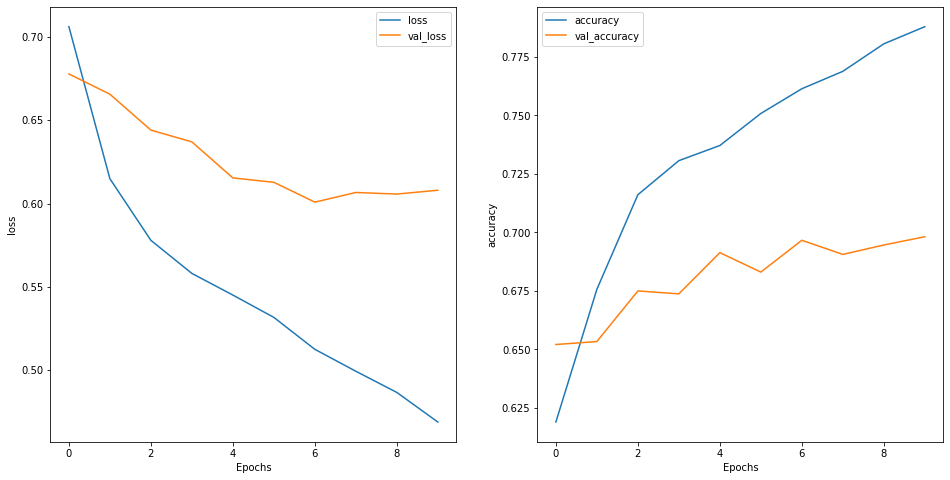

In [ ]:
history = model.fit(X_train_one_hot, y_train_one_hot, validation_data=(X_test_one_hot, y_test_one_hot), epochs=10, batch_size=5, shuffle=True) # validation set
view_graphs(history)

**Predict**

In [ ]:
_, accuracy = model.evaluate(X_test_one_hot, y_test_one_hot)

125/125 [==============================] - 15s 65ms/step - loss: 0.6930 - accuracy: 0.6126


In [ ]:
from sklearn.metrics import classification_report
y_predict = model.predict(X_test_one_hot)
print(y_predict)

[[0.5011127  0.4988872 ]
 [0.5000525  0.49994752]
 [0.49992478 0.50007516]
 ...
 [0.50046146 0.49953848]
 [0.5004395  0.49956048]
 [0.50113314 0.49886683]]


**Find Accuracy**

**Create LSTM Model**

In [24]:
model = Sequential([
Embedding(vocab_length, 30, input_length=max_len,mask_zero=True),
LSTM(64, return_sequences=True),
Dropout(0.7),
LSTM(32),
Dropout(0.6),
Dense(max_len, activation='relu'),
Dense(y_train_one_hot.shape[1], activation='softmax')     
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics="accuracy")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 253, 30)           30000     
                                                                 
 lstm (LSTM)                 (None, 253, 64)           24320     
                                                                 
 dropout_4 (Dropout)         (None, 253, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 253)               8349      
                                                                 
 dense_3 (Dense)             (None, 2)                

**Run LSTM MOdel**

Epoch 1/10
927/927 [==============================] - 334s 351ms/step - loss: 0.6314 - get_f1: 0.6686 - val_loss: 0.5852 - val_get_f1: 0.7095
Epoch 2/10
927/927 [==============================] - 322s 348ms/step - loss: 0.5464 - get_f1: 0.7304 - val_loss: 0.5862 - val_get_f1: 0.7166
Epoch 3/10
927/927 [==============================] - 323s 348ms/step - loss: 0.5274 - get_f1: 0.7391 - val_loss: 0.5820 - val_get_f1: 0.7095
Epoch 4/10
927/927 [==============================] - 322s 348ms/step - loss: 0.4960 - get_f1: 0.7626 - val_loss: 0.5827 - val_get_f1: 0.7018
Epoch 5/10
927/927 [==============================] - 323s 348ms/step - loss: 0.4725 - get_f1: 0.7695 - val_loss: 0.6406 - val_get_f1: 0.6962
Epoch 6/10
927/927 [==============================] - 323s 348ms/step - loss: 0.4438 - get_f1: 0.7835 - val_loss: 0.7196 - val_get_f1: 0.6852
Epoch 7/10
927/927 [==============================] - 323s 349ms/step - loss: 0.4247 - get_f1: 0.7921 - val_loss: 0.7303 - val_get_f1: 0.6809
Epoch 

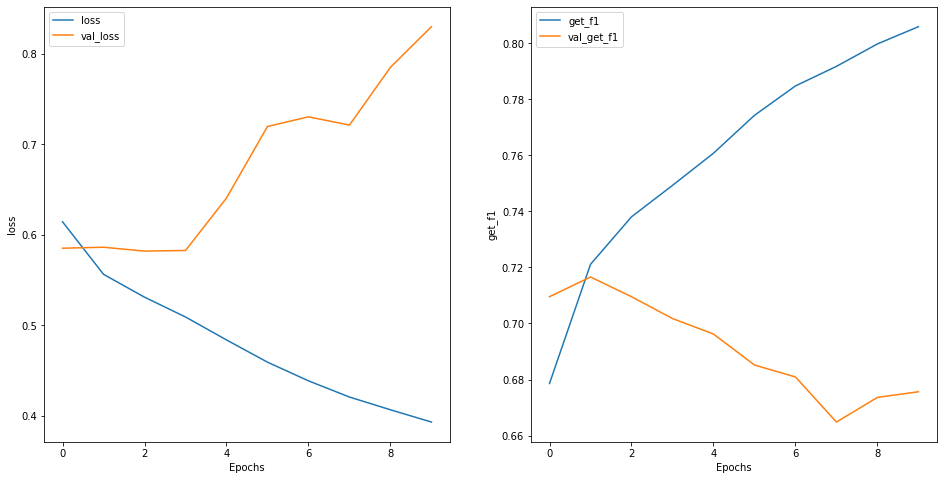

In [ ]:
history = model.fit(X_train_one_hot, y_train_one_hot, validation_data=(X_test_one_hot, y_test_one_hot), epochs=10, batch_size=10, shuffle=True) # validation set plot data
view_graphs(history)

**Predict LSTM MOdel output**

In [ ]:
from sklearn.metrics import classification_report
y_predict = model.predict(X_test_one_hot)
print(y_predict)

[[0.4997308  0.5002692 ]
 [0.50028163 0.49971843]
 [0.4983896  0.50161046]
 ...
 [0.49859193 0.50140804]
 [0.49931166 0.5006884 ]
 [0.4982973  0.50170267]]


**Find LSTM Mdel accuracy**

In [ ]:
_, accuracy = model.evaluate(X_test_one_hot, y_test_one_hot)
print('Accuracy: %.2f' % (accuracy*100))

125/125 [==============================] - 5s 42ms/step - loss: 0.6936 - get_f1: 0.4150
Accuracy: 41.50


**Applying K-fold validation**



**Dense model in K-fold cross validation**

Fold #1
TRAIN: [    1     2     3 ... 13235 13237 13239] TEST: [    0     8    14 ... 13233 13236 13238]
x shape: 253 y shape: 1
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 253, 30)           30000     
                                                                 
 dense_8 (Dense)             (None, 253, 64)           1984      
                                                                 
 dropout_9 (Dropout)         (None, 253, 64)           0         
                                                                 
 dense_9 (Dense)             (None, 253, 32)           2080      
                                                                 
 dropout_10 (Dropout)        (None, 253, 32)           0         
                                                                 
 dense_10 (Dense)            (None, 253, 16)           52

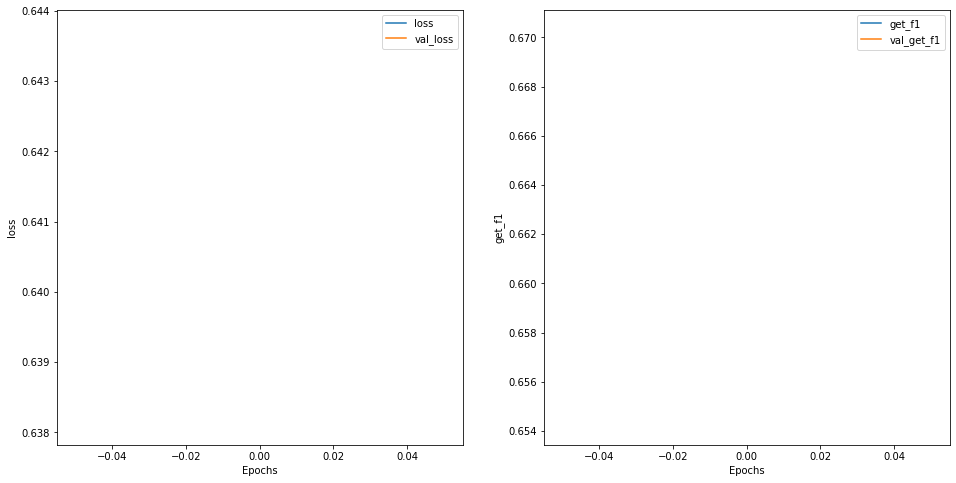

Fold score (categorical_crossentropy): [0.65076396 0.35153697 0.35438102 ... 0.35171224 0.35453151 0.64885166]
Fold #2
TRAIN: [    0     1     2 ... 13237 13238 13239] TEST: [    3    10    12 ... 13225 13228 13231]
x shape: 253 y shape: 1
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 253, 30)           30000     
                                                                 
 dense_12 (Dense)            (None, 253, 64)           1984      
                                                                 
 dropout_12 (Dropout)        (None, 253, 64)           0         
                                                                 
 dense_13 (Dense)            (None, 253, 32)           2080      
                                                                 
 dropout_13 (Dropout)        (None, 253, 32)           0         
            

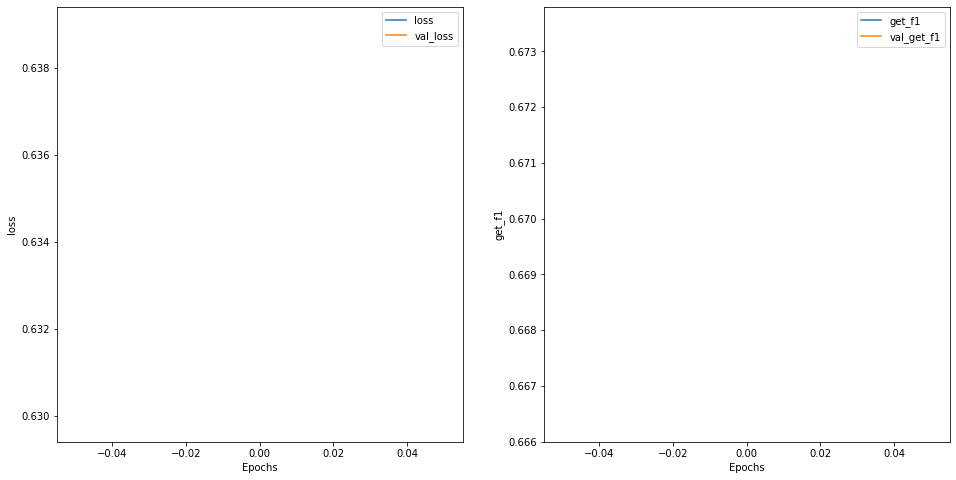

Fold score (categorical_crossentropy): [0.66232188 0.33373465 0.65138198 ... 0.35362409 0.34982856 0.33347422]
Fold #3
TRAIN: [    0     1     2 ... 13236 13237 13238] TEST: [   15    26    27 ... 13234 13235 13239]
x shape: 253 y shape: 1
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 253, 30)           30000     
                                                                 
 dense_16 (Dense)            (None, 253, 64)           1984      
                                                                 
 dropout_15 (Dropout)        (None, 253, 64)           0         
                                                                 
 dense_17 (Dense)            (None, 253, 32)           2080      
                                                                 
 dropout_16 (Dropout)        (None, 253, 32)           0         
            

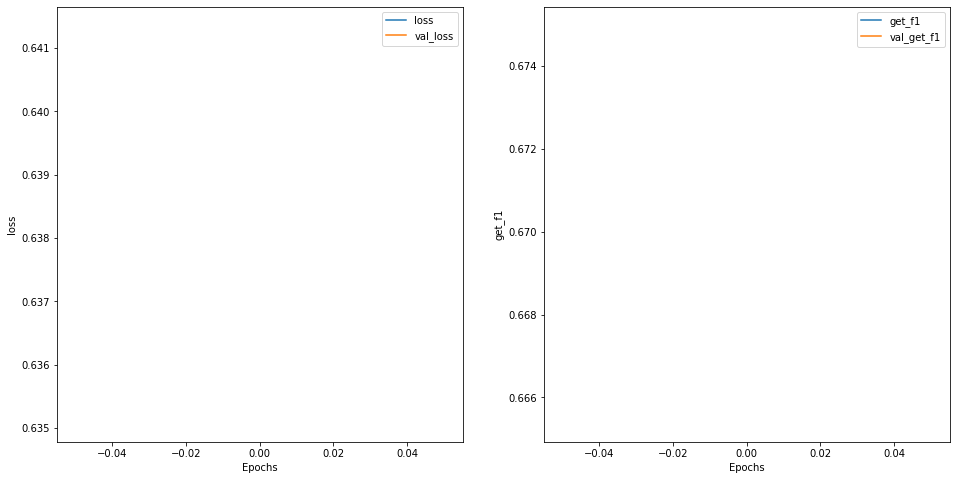

Fold score (categorical_crossentropy): [0.37016916 0.38207749 0.37054989 ... 0.3735823  0.61990595 0.3749762 ]
Fold #4
TRAIN: [    0     1     3 ... 13237 13238 13239] TEST: [    2     6     7 ... 13229 13230 13232]
x shape: 253 y shape: 1
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 253, 30)           30000     
                                                                 
 dense_20 (Dense)            (None, 253, 64)           1984      
                                                                 
 dropout_18 (Dropout)        (None, 253, 64)           0         
                                                                 
 dense_21 (Dense)            (None, 253, 32)           2080      
                                                                 
 dropout_19 (Dropout)        (None, 253, 32)           0         
            

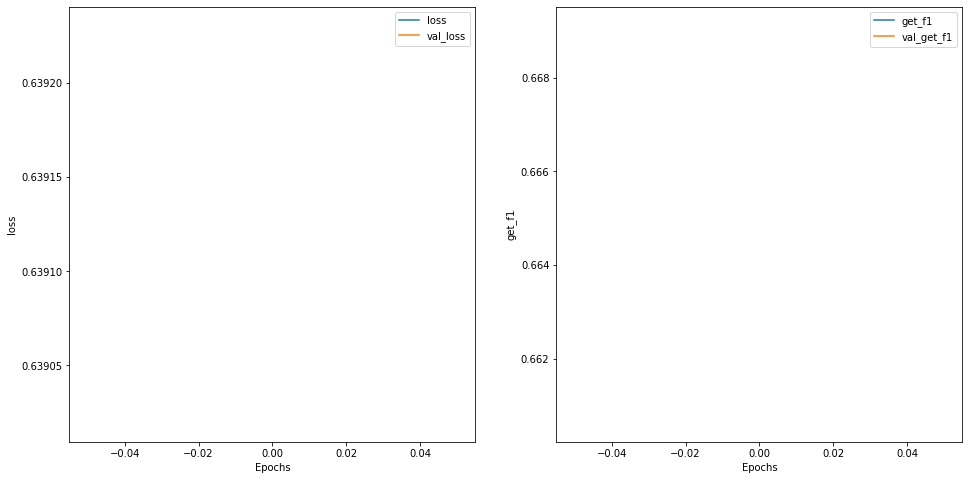

Fold score (categorical_crossentropy): [0.36312275 0.65339075 0.63365696 ... 0.37341945 0.36680211 0.34627572]
Fold #5
TRAIN: [    0     2     3 ... 13236 13238 13239] TEST: [    1     4     5 ... 13223 13226 13237]
x shape: 253 y shape: 1
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 253, 30)           30000     
                                                                 
 dense_24 (Dense)            (None, 253, 64)           1984      
                                                                 
 dropout_21 (Dropout)        (None, 253, 64)           0         
                                                                 
 dense_25 (Dense)            (None, 253, 32)           2080      
                                                                 
 dropout_22 (Dropout)        (None, 253, 32)           0         
            

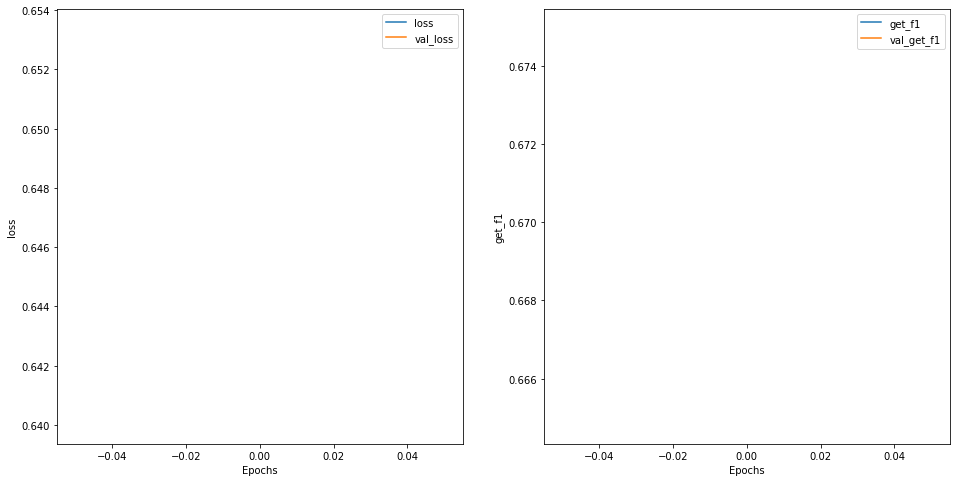

Fold score (categorical_crossentropy): [0.57154272 0.42954797 0.57601793 ... 0.55410223 0.42383546 0.5732719 ]
Final, out of sample score (RMSE): [0.65076396 0.35153697 0.35438102 ... 0.55410223 0.42383546 0.5732719 ]


In [26]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = True, random_state=42)
out_sample_y = []
out_sample_pred = []
fold = 0
for train_index, test_index in kf.split(X):
    fold+=1
    print(f"Fold #{fold}")

    print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    max_len = max(len(max(X_train,key=lambda x:len(x))),
              len(max(X_test,key=lambda x:len(x))))
    
    X_train_one_hot = [one_hot(x, vocab_length) for x in X_train]
    X_train_one_hot = pad_sequences(X_train_one_hot, maxlen=max_len, padding='post')
    X_test_one_hot = [one_hot(x, vocab_length) for x in X_test]
    X_test_one_hot = pad_sequences(X_test_one_hot, maxlen=max_len, padding='post')

    y_train = y_train.apply(lambda x: 0 if x == "NOT" else 1)
    y_test = y_test.apply(lambda x: 0 if x == "NOT" else 1)
    y_train = y_train.values.reshape(-1,1)
    y_test = y_test.values.reshape(-1,1)
    y_train_one_hot = encoder.fit_transform(np.array(y_train)).toarray()
    y_test_one_hot = encoder.transform(np.array(y_test)).toarray()
    
    print("x shape:", X_train_one_hot.shape[1], "y shape:", y_train.shape[1])
    
    model = Sequential([
    Embedding(vocab_length, 30, input_length=max_len,mask_zero=True),
    Dense(units=64, activation='relu',input_shape=(X_train_one_hot.shape[1],)),
    Dropout(0.5),
    Dense(units=32, activation='relu'),
    Dropout(0.5),
    Dense(units=16, activation='relu'),
    Dropout(0.5),
    Flatten(),
    Dense(y_train_one_hot.shape[1],activation='softmax'),
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=get_f1)
    model.summary()
    
    history = model.fit(X_train_one_hot,y_train_one_hot,validation_data=(X_test_one_hot,y_test_one_hot),verbose=0,
              epochs=1)
    view_graphs(history)
    pred = model.predict(X_test_one_hot)
    
    out_sample_y.append(y_test_one_hot)
    out_sample_pred.append(pred)

    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test_one_hot))
    print(f"Fold score (categorical_crossentropy): {score}")

# Build the oos prediction list and calculate the error.
out_sample_y = np.concatenate(out_sample_y)
out_sample_pred = np.concatenate(out_sample_pred)
score = np.sqrt(metrics.mean_squared_error(out_sample_pred,out_sample_y))
print(f"Final, out of sample score (RMSE): {score}")
    
# Write the cross-validated prediction
out_sample_y = pd.DataFrame(out_sample_y)
out_sample_pred = pd.DataFrame(out_sample_pred)
out_sample_data = pd.concat( [out_sample_y, out_sample_pred],axis=1 )

In [27]:
out_sample_data.head()

,0,1,0,1
0,0.0,1.0,0.650764,0.349236
1,1.0,0.0,0.648463,0.351537
2,1.0,0.0,0.645619,0.354381
3,1.0,0.0,0.631156,0.368844
4,0.0,1.0,0.646684,0.353316
